In [24]:
import _init_paths
from PIL import Image
import numpy as np
import cv2
import random

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown
from vcl.models.components.vqvae import VQVAE
from vcl.models.vqvae import *
from vcl.utils import *
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

import matplotlib.pyplot as plt
%matplotlib inline

target_image_size = 256

samples = []
with open('/home/lr/dataset/YouTube-VOS/2018/train/test_records.txt', 'r') as f:
    for line in f.readlines():
        name, frame_idx, pixel_idx = line.strip('\n').split()
        samples.append([name, int(frame_idx), int(pixel_idx)])

def visualize_vqvae(z1_q, z2_q, frame1, frame2, x_rec1, x_rec2, nembed=2048, rescale=True, mask=None):
    frame_vq_1 = z1_q.permute(1,2,0).numpy()
    frame_vq_2 = z2_q.permute(1,2,0).numpy()

    print(len(np.unique(frame_vq_1)))

    if rescale:
        frame_vq_1 = (frame_vq_1 * 255 / nembed).astype(np.uint8)
        frame_vq_2 = (frame_vq_2 * 255 / nembed).astype(np.uint8)
    else:
        frame_vq_1 = (frame_vq_1).astype(np.uint8)
        frame_vq_2 = (frame_vq_2).astype(np.uint8)

    if mask is not None:

        frame_vq_2 = frame_vq_2 * mask

    plt.rcParams['figure.dpi'] = 200

    plt.figure()

    if x_rec1 is not None:
        plt.subplot(3,2,1)
        plt.imshow(frame_vq_1, cmap=plt.get_cmap('jet'))
        plt.subplot(3,2,2)
        plt.imshow(frame_vq_2, cmap=plt.get_cmap('jet'))

        plt.subplot(3,2,3)
        plt.imshow(np.array(frame1))

        plt.subplot(3,2,4)
        plt.imshow(np.array(frame2))

        plt.subplot(3,2,5)
        plt.imshow(np.array(x_rec1))

        plt.subplot(3,2,6)
        plt.imshow(np.array(x_rec2))

        plt.show()
    else:
        plt.subplot(2,2,1)
        plt.imshow(frame_vq_1, cmap=plt.get_cmap('jet'))
        plt.subplot(2,2,2)
        plt.imshow(frame_vq_2, cmap=plt.get_cmap('jet'))

        plt.subplot(2,2,3)
        plt.imshow(np.array(frame1))

        plt.subplot(2,2,4)
        plt.imshow(np.array(frame2))


def visualize_correspondence(z1_q, z2_q, sample_idx, frame1, frame2, scale=32):
    plt.rcParams['figure.dpi'] = 200

    z1_q = z1_q[0].numpy()
    z2_q = z2_q[0].numpy()
    find = False
    count = 0

    while not find:
        x, y = sample_idx % scale, sample_idx // scale

        query = z1_q[y,x]
        m = (z2_q == query).astype(np.uint8) * 255
        count += 1

        if m.max() > 1:
            find = True
        else:
            # sample_idx = random.randint(0, scale*scale -1)
            sample_idx = random.randint(210, 250)
            print('not find, change query')
        
    print(f"find correspodence at {count}")   

    querys_map = np.zeros((scale,scale))
    querys_map[y,x] = 255
    querys_map = querys_map.astype(np.uint8)
    

    plt.figure()
    plt.subplot(2,2,1)
    plt.imshow(querys_map, cmap=plt.get_cmap('jet'))
    plt.subplot(2,2,2)
    plt.imshow(m, cmap=plt.get_cmap('jet'))
    plt.subplot(2,2,3)
    plt.imshow(np.array(frame1))

    plt.subplot(2,2,4)
    plt.imshow(np.array(frame2))
    

def preprocess_(img):
    
    mean=np.array([123.675, 116.28, 103.53])
    std=np.array([58.395, 57.12, 57.375])
    
    # resize
    img = img.astype(np.float32)
    
    mmcv.imnormalize_(img, mean, std, False)
    
    out = torch.from_numpy(img).unsqueeze(0).permute(0, 3, 1, 2)
    return out


def main_vqvae(model, nembed=32, rescale=False, decode=True):
    _, quant1, diff, ind1, embed = model.encode(x1.cuda())
    _, quant2, diff, ind2, embed = model.encode(x2.cuda())

    print(len(np.unique(ind1.cpu().numpy())))

    if decode:
        dec1 = model.decode(quant1)[0]
        dec2 = model.decode(quant2)[0]

        dec1 = tensor2img(dec1.detach().cpu(), norm_mode='mean-std')
        dec2 = tensor2img(dec2.detach().cpu(), norm_mode='mean-std')
        dec1 = cv2.cvtColor(dec1, cv2.COLOR_BGR2RGB)
        dec2 = cv2.cvtColor(dec2, cv2.COLOR_BGR2RGB)
    else:
        dec1 = None
        dec2 = None

    visualize_vqvae(ind1.cpu(), ind2.cpu(), frame1, frame2, dec1, dec2, nembed=nembed, rescale=rescale)
    # visualize corr for origin vqvae
    visualize_correspondence(ind1.cpu(), ind2.cpu(), sample_idx, frame1, frame2, scale=32)

In [25]:
# sample frame
import os.path as osp
import glob


# sample_video_idx = 92
sample_video_idx = random.randint(0, 300)
sample = {}
sample['frames_path'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx][0], '*.jpg')))


frame_idx = samples[sample_video_idx][1]
sample_idx = samples[sample_video_idx][2]
video_name = sample['frames_path'][0].split('/')[-2]


frame1 = cv2.imread(sample['frames_path'][frame_idx])[:,:,::-1]
frame2 = cv2.imread(sample['frames_path'][frame_idx+1])[:,:,::-1]
frame1 = cv2.resize(frame1, (256,256))
frame2 = cv2.resize(frame2, (256,256))

print('sample frames from {}'.format(sample['frames_path'][0]))

x1 = preprocess_(frame1)
x2 = preprocess_(frame2)

sample frames from /home/lr/dataset/YouTube-VOS/2018/train/JPEGImages/8d064b29e2/00000.jpg


Use load_from_local loader
19
19
find correspodence at 1


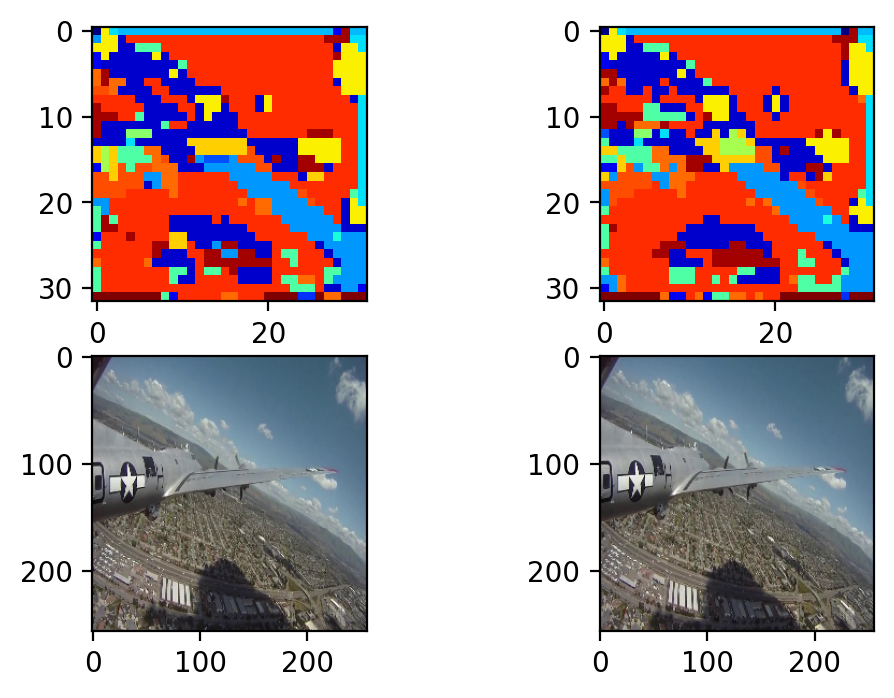

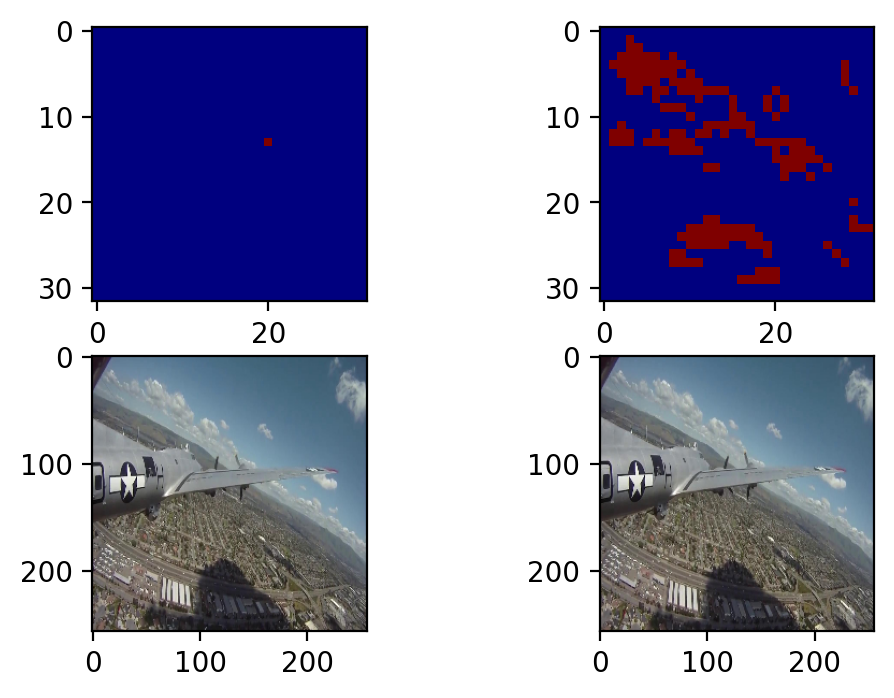

In [26]:
model = VQCL_v2(backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    sim_siam_head=dict(
        type='SimSiamHead',
        in_channels=512,
        # norm_cfg=dict(type='SyncBN'),
        num_projection_fcs=3,
        projection_mid_channels=512,
        projection_out_channels=512,
        num_predictor_fcs=2,
        predictor_mid_channels=128,
        predictor_out_channels=512,
        with_norm=True,
        spatial_type='avg'),
    loss=dict(type='CosineSimLoss', negative=False),
    embed_dim=128,
    n_embed=32,
    commitment_cost=1.0,)
_ = load_checkpoint(model, '/home/lr/models/vqvae/vqvae_youtube_d4_n32_c256_embc128_byol_commit1.0.pth', map_location='cpu')

model = model.cuda()
model.eval()
main_vqvae(model, decode=False)

Use load_from_local loader
16
16
find correspodence at 1


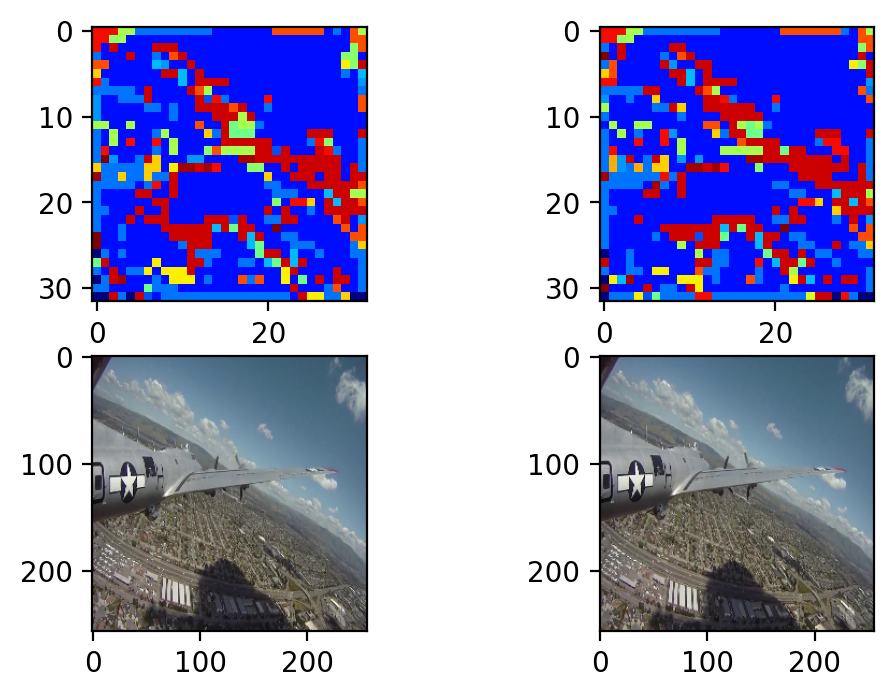

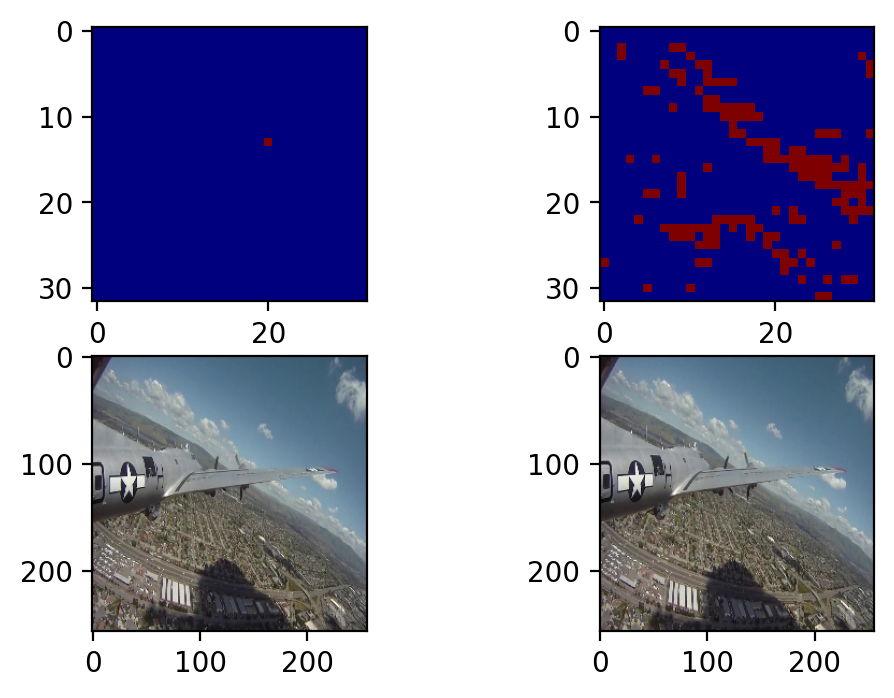

In [27]:
model = VQCL_v5(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    sim_siam_head=dict(
        type='SimSiamHead',
        in_channels=128,
        # norm_cfg=dict(type='SyncBN'),
        num_projection_fcs=3,
        projection_mid_channels=128,
        projection_out_channels=128,
        num_predictor_fcs=2,
        predictor_mid_channels=128,
        predictor_out_channels=128,
        with_norm=True,
        spatial_type='avg'),
    loss=dict(type='CosineSimLoss', negative=False),
    embed_dim=128,
    n_embed=32,
    commitment_cost=1.0
    )
_ = load_checkpoint(model, '/home/lr/expdir/VCL/group_vqvae_tracker/train_vqvae_video_d4_nemd32_contrastive_byol_commit1.0_v2/epoch_3200.pth', map_location='cpu')

model = model.cuda()
model.eval()
main_vqvae(model, decode=False)

Use load_from_local loader
180
180
find correspodence at 1


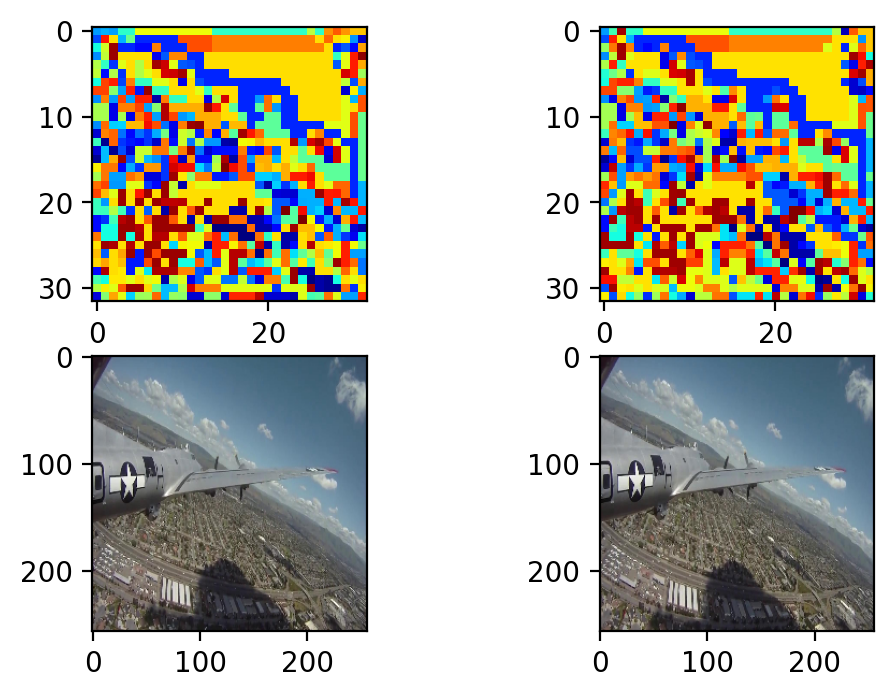

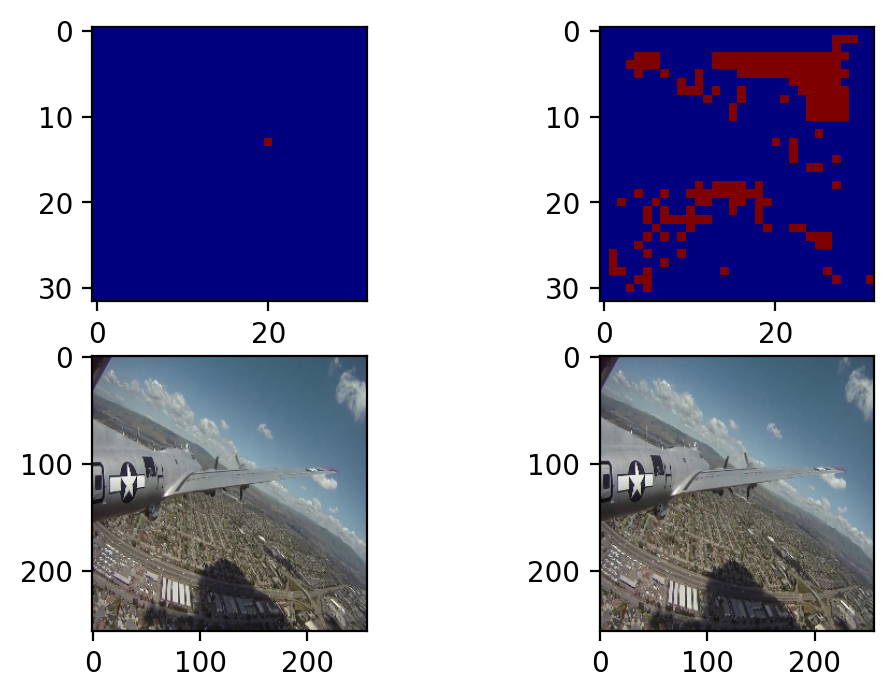

In [28]:
model = VQCL_v5(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    sim_siam_head=dict(
        type='SimSiamHead',
        in_channels=128,
        # norm_cfg=dict(type='SyncBN'),
        num_projection_fcs=3,
        projection_mid_channels=128,
        projection_out_channels=128,
        num_predictor_fcs=2,
        predictor_mid_channels=128,
        predictor_out_channels=128,
        with_norm=True,
        spatial_type='avg'),
    loss=dict(type='CosineSimLoss', negative=False),
    embed_dim=128,
    n_embed=2048,
    commitment_cost=1.0
    )
_ = load_checkpoint(model, '/home/lr/expdir/VCL/group_vqvae_tracker/train_vqvae_video_d4_nemd2048_contrastive_byol_commit1.0_v2/epoch_3200.pth', map_location='cpu')

model = model.cuda()
model.eval()
main_vqvae(model, decode=False)

Use load_from_local loader
66
66
find correspodence at 1


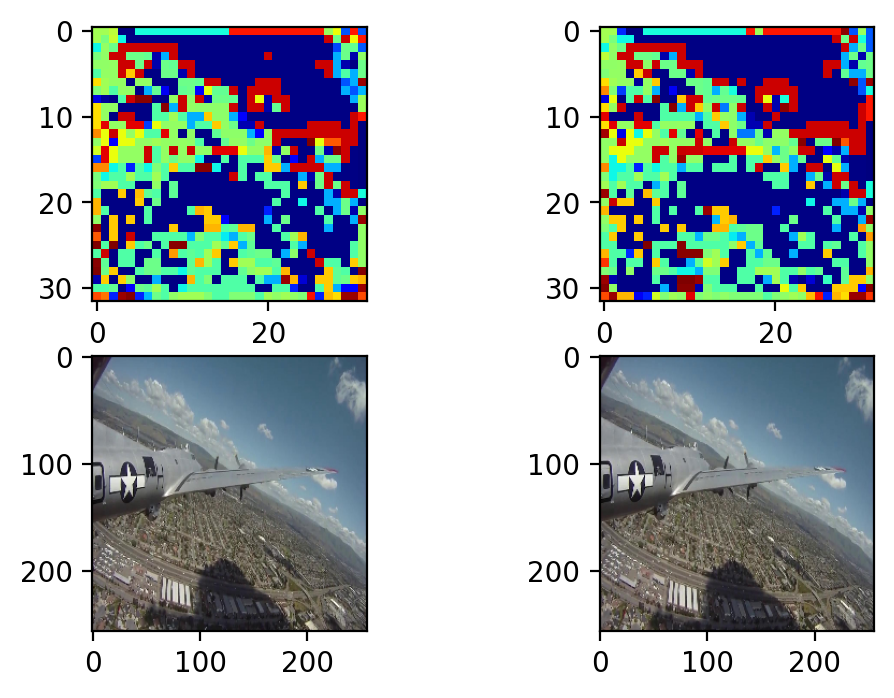

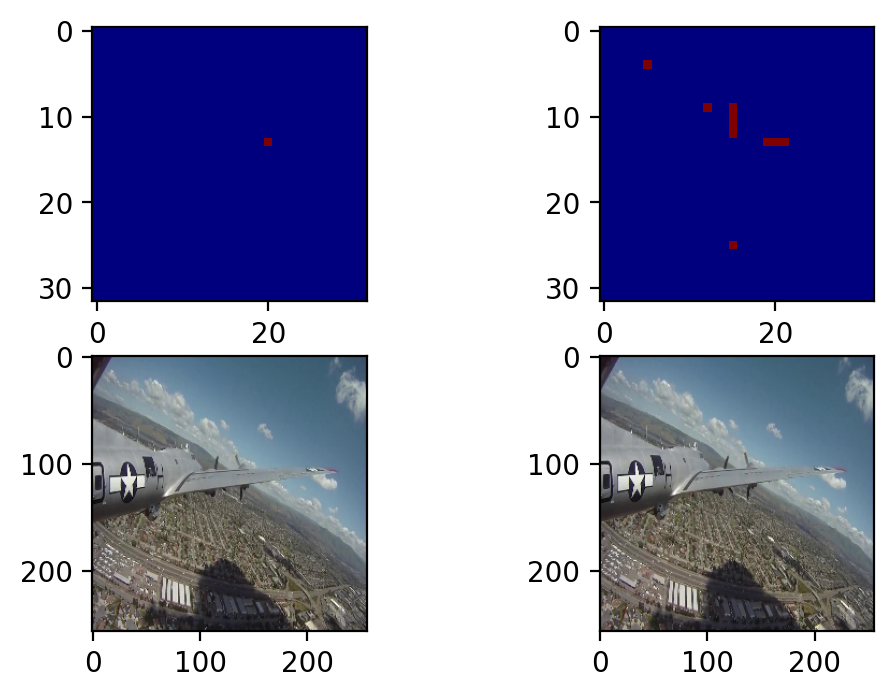

In [29]:
model = VQCL_v5(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    sim_siam_head=dict(
        type='SimSiamHead',
        in_channels=128,
        # norm_cfg=dict(type='SyncBN'),
        num_projection_fcs=3,
        projection_mid_channels=128,
        projection_out_channels=128,
        num_predictor_fcs=2,
        predictor_mid_channels=128,
        predictor_out_channels=128,
        with_norm=True,
        spatial_type='avg'),
    loss=dict(type='CosineSimLoss', negative=False),
    embed_dim=128,
    n_embed=2048,
    commitment_cost=1.0
    )
_ = load_checkpoint(model, '/home/lr/expdir/VCL/group_vqvae_tracker/train_vqvae_video_d4_nemd2048_contrastive_byol_commit0.25_v2_2/epoch_12800.pth', map_location='cpu')

model = model.cuda()
model.eval()
main_vqvae(model, decode=False)